In [1]:
import os
os.environ['PRISMATIC_DATA_ROOT'] = ''
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("../..")
from libero.libero import benchmark

from experiments.robot.libero.libero_utils import (
    get_libero_dummy_action,
    get_libero_env,
    get_libero_image,
    quat2axisangle,
)
from experiments.robot.openvla_utils import get_processor, get_vla, get_prismatic_vla
from experiments.robot.robot_utils import (
    get_image_resize_size,
    invert_gripper_action,
    normalize_gripper_action,
    set_seed_everywhere,
)

from dataclasses import dataclass
from pathlib import Path
from typing import Union, List, Dict, Any, Optional, Tuple
import numpy as np
import torch
import time
import tqdm

assert torch.cuda.is_available(), "ERROR: CUDA not available!"

os.system("nvidia-smi")



2026-01-10 15:42:16.791276: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 15:42:16.825420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-10 15:42:16.825454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-10 15:42:16.826483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-10 15:42:16.832326: I tensorflow/core/platform/cpu_feature_guar

Sat Jan 10 15:42:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                On  |   00000000:81:00.0 Off |                    0 |
| N/A   44C    P0             74W /  400W |   18115MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

0

  ### config

In [2]:
@dataclass
class BenchmarkConfig:
    # fmt: off
    target_checkpoint: Union[str, Path] = "/pub/scratch/aagouzoul/ovla/openvla-mini/ft_experiments_logs/openvla-7b+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug_step-75000_l1-loss-0.0012_tokacc-0.955"
    draft_checkpoint: Union[str, Path] = "Stanford-ILIAD/minivla-libero90-prismatic"
    hf_token: str = Path("/pub/scratch/aagouzoul/ovla/openvla-mini/.hf_token")
    load_in_8bit: bool = False
    load_in_4bit: bool = False
    center_crop: bool = True
    
    # Speculative decoding parameters
    gamma: int = 7
    temperature: float = 0.0
    relaxed_acceptance_r: int = 0
    
    # Benchmark parameters
    task_suite_name: str = "libero_90"
    task_id: int = 0
    num_steps_wait: int = 10
    max_steps_override: Optional[int] = None
    warmup_steps: int = 5  # warmup policy calls at start of rollout
    seed: int = 42
    
    # fmt: on
    
cfg = BenchmarkConfig()

print("=" * 80)
print("Speculative Decoding Throughput Benchmark (Full Rollout)")
print("=" * 80)
print(f"Target: {cfg.target_checkpoint}")
print(f"Draft: {cfg.draft_checkpoint}")
print(f"Gamma: {cfg.gamma}")
print(f"Task: {cfg.task_suite_name} (task {cfg.task_id})")
print("=" * 80)

set_seed_everywhere(cfg.seed)

class TargetConfig:
    def __init__(self, c):
        self.pretrained_checkpoint = c.target_checkpoint
        self.load_in_8bit = c.load_in_8bit
        self.load_in_4bit = c.load_in_4bit
        self.hf_token = c.hf_token

class DraftConfig:
    def __init__(self, c):
        self.pretrained_checkpoint = c.draft_checkpoint
        self.model_family = "prismatic"
        self.hf_token = c.hf_token
        self.center_crop = c.center_crop



Speculative Decoding Throughput Benchmark (Full Rollout)
Target: /pub/scratch/aagouzoul/ovla/openvla-mini/ft_experiments_logs/openvla-7b+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug+libero_90_no_noops+b32+lr-0.0005+lora-r32+dropout-0.0--image_aug_step-75000_l1-loss-0.0012_tokacc-0.955
Draft: Stanford-ILIAD/minivla-libero90-prismatic
Gamma: 7
Task: libero_90 (task 0)


  ### Helper functions

In [3]:
def _max_steps_for_suite(task_suite_name: str) -> int:
    if task_suite_name == "libero_spatial":
        return 220
    if task_suite_name == "libero_object":
        return 280
    if task_suite_name == "libero_goal":
        return 300
    if task_suite_name == "libero_10":
        return 520
    if task_suite_name == "libero_90":
        return 400
    return 400


def _summarize_ms(xs: List[float]) -> Dict[str, float]:
    if len(xs) == 0:
        return {"n": 0}
    arr = np.asarray(xs, dtype=np.float64)
    return {
        "n": float(arr.size),
        "mean_ms": float(arr.mean()),
        "std_ms": float(arr.std()),
        "min_ms": float(arr.min()),
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "max_ms": float(arr.max()),
        "hz": float(1000.0 / arr.mean()) if arr.mean() > 0 else float("nan"),
    }



  ### load models

In [4]:
print("\n[1/4] Loading TARGET model (OpenVLA)...")
target_cfg = TargetConfig(cfg)
target_model = get_vla(target_cfg)
target_processor = get_processor(target_cfg)

print("\n[2/4] Loading DRAFT model (MiniVLA)...")
draft_cfg = DraftConfig(cfg)
draft_model = get_prismatic_vla(draft_cfg)

# Set unnorm key
unnorm_key_target = cfg.task_suite_name
if unnorm_key_target not in target_model.norm_stats:
    if f"{unnorm_key_target}_no_noops" in target_model.norm_stats:
        unnorm_key_target = f"{unnorm_key_target}_no_noops"
    elif f"{unnorm_key_target.replace('_no_noops', '')}" in target_model.norm_stats:
        unnorm_key_target = f"{unnorm_key_target}"
    else:
        unnorm_key_target = list(target_model.norm_stats.keys())[0]
        
unnorm_key_draft = cfg.task_suite_name
if unnorm_key_draft not in draft_model.norm_stats:
    if f"{unnorm_key_draft}_no_noops" in draft_model.norm_stats:
        unnorm_key_draft = f"{unnorm_key_draft}_no_noops"
    elif f"{unnorm_key_draft.replace('_no_noops', '')}" in draft_model.norm_stats:
        unnorm_key_draft = f"{unnorm_key_draft}"
    else:
        unnorm_key_draft = list(draft_model.norm_stats.keys())[0]

print(f"Using unnorm_keys: {unnorm_key_target} (target), {unnorm_key_draft} (draft)")




[1/4] Loading TARGET model (OpenVLA)...
[*] Instantiating Pretrained VLA model
[*] Loading in BF16 with Flash-Attention Enabled


<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[SRPPPPPPPPPP] -> .eval() + torch.compile(vla) DISABLED

[2/4] Loading DRAFT model (MiniVLA)...
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [15:42:47] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=234053;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=146316;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=571858;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=91161;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

01/10 [15:42:48] INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=229258;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=243962;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=750800;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=681453;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=617889;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=291704;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#236\236]8;;\

01/10 [15:42:51] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=732052;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=443143;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=107175;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=97251;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=277370;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=846335;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [15:42:55] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=130889;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=967096;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=869693;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=659176;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=201629;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=738797;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=83667;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=896865;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [15:43:01] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=475435;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=666563;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=219684;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py\load.py]8;;\:]8;id=702729;file:///pub/scratch/aagouzoul/ovla/openvla-mini/experiments/specdec/../../prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Using unnorm_keys: libero_90_no_noops (target), libero_90 (draft)


In [5]:
# Load LIBERO task
print(f"\n[3/4] Loading LIBERO task: {cfg.task_suite_name} (task {cfg.task_id})...")
benchmark_dict = benchmark.get_benchmark_dict()
task_suite = benchmark_dict[cfg.task_suite_name]()
task = task_suite.get_task(cfg.task_id)
env, task_description = get_libero_env(task, "openvla", resolution=224)

initial_states = task_suite.get_task_init_states(cfg.task_id)
max_steps = cfg.max_steps_override if cfg.max_steps_override is not None else _max_steps_for_suite(cfg.task_suite_name)

print(f"Task: {task_description}")
print(f"Max steps: {max_steps}")




[3/4] Loading LIBERO task: libero_90 (task 0)...
Task: close the top drawer of the cabinet
Max steps: 400


In [6]:
# Setup inference functions
from experiments.robot.openvla_utils import get_vla_action
from experiments.specdec.minivla_fastpath import MiniVLAFastPath

draft_fast = MiniVLAFastPath(
    model=draft_model,
    instruction=task_description,
    unnorm_key=unnorm_key_draft,
    center_crop=cfg.center_crop,  
    compile_llm=True,            
    compile_mode="default",
    compile_vision=True,   
    compile_mode_vision="reduce-overhead",
)


def timed_cuda(fn):
    """Time a function using CUDA events for accurate GPU timing."""
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end)  # Returns ms



  ### Speculative Decoding Implementation



 Import from benchmark_specdec_throughput.py

In [7]:
import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union
import torch.nn.functional as F
from PIL import Image
from transformers.cache_utils import DynamicCache

# Cache utilities
def prune_cache(
    cache: Union[Tuple[Tuple[torch.Tensor, torch.Tensor]], DynamicCache, None],
    num_tokens_to_discard: int,
) -> Union[Tuple[Tuple[torch.Tensor, torch.Tensor]], DynamicCache, None]:
    if cache is None or num_tokens_to_discard <= 0:
        return cache
    
    if isinstance(cache, DynamicCache):
        for layer in range(len(cache)):
            cache.key_cache[layer] = cache.key_cache[layer][:, :, :-num_tokens_to_discard, :]
            cache.value_cache[layer] = cache.value_cache[layer][:, :, :-num_tokens_to_discard, :]
        cache._seen_tokens -= num_tokens_to_discard
        return cache
    
    elif isinstance(cache, tuple):
        new_cache = []
        for layer_cache in cache:
            if layer_cache is None:
                new_cache.append(None)
                continue
            layer = []
            for tensor in layer_cache:
                new_tensor = tensor[:, :, :-num_tokens_to_discard, :]
                layer.append(new_tensor)
            new_cache.append(tuple(layer))
        return tuple(new_cache)
    
    else:
        raise ValueError(f"Unsupported cache type: {type(cache)}")

# Image preprocessing
def apply_center_crop(im: np.ndarray, t_h: int, t_w: int) -> np.ndarray:
    assert im.shape[-3] >= t_h and im.shape[-2] >= t_w
    crop_h = int((im.shape[-3] - t_h) / 2)
    crop_w = int((im.shape[-2] - t_w) / 2)
    return im[..., crop_h : crop_h + t_h, crop_w : crop_w + t_w, :]

def prepare_image(full_image: Union[np.ndarray, List[np.ndarray]], center_crop: bool = False) -> Image.Image:
    if isinstance(full_image, list):
        full_image = full_image[0]
    
    image = Image.fromarray(full_image).convert("RGB")
    
    if center_crop:
        temp_image = np.array(image)
        crop_scale = 0.9
        sqrt_crop_scale = math.sqrt(crop_scale)
        temp_image_cropped = apply_center_crop(
            temp_image,
            t_h=int(sqrt_crop_scale * temp_image.shape[0]),
            t_w=int(sqrt_crop_scale * temp_image.shape[1]),
        )
        image = Image.fromarray(temp_image_cropped)
        image = image.resize((224, 224), Image.Resampling.BILINEAR)
    
    return image

# Stats dataclass
@dataclass
class SpeculativeDecodingStats:
    total_tokens_generated: int = 0
    total_draft_tokens_proposed: int = 0
    total_draft_tokens_accepted: int = 0
    total_target_forward_passes: int = 0
    total_draft_forward_passes: int = 0
    
    @property
    def acceptance_rate(self) -> float:
        if self.total_draft_tokens_proposed == 0:
            return 0.0
        return self.total_draft_tokens_accepted / self.total_draft_tokens_proposed
    
    @property
    def tokens_per_target_forward(self) -> float:
        if self.total_target_forward_passes == 0:
            return 0.0
        return self.total_tokens_generated / self.total_target_forward_passes

def max_fn(x: torch.Tensor) -> torch.Tensor:
    x_max = torch.where(x > 0, x, torch.zeros_like(x))
    x_max_sum = torch.sum(x_max, dim=-1, keepdim=True)
    return x_max / (x_max_sum + 1e-10)


class VLASpeculativeDecoderBatchedLM:
    def __init__(
        self,
        target_model,
        draft_model,
        target_processor=None,
        gamma: int = 4,
        temperature: float = 0.0,
        n_action_bins: int = 256,
        relaxed_acceptance_r: int = 0,
        verbose: bool = False,
    ):
        self.verbose = verbose
        
        self.target = target_model
        self.draft = draft_model
        self.target_processor = target_processor
        self.gamma = gamma
        self.temperature = temperature
        self.n_action_bins = n_action_bins
        self.relaxed_acceptance_r = relaxed_acceptance_r
        
        self.device = next(target_model.parameters()).device
        self.stats = SpeculativeDecodingStats()
        self._setup_token_mapping()
        
    def _setup_token_mapping(self):
        if hasattr(self.target, 'language_model') and hasattr(self.target.language_model, 'model'):
            self.target_logit_dim = self.target.language_model.model.embed_tokens.weight.shape[0]
        elif hasattr(self.target, 'get_output_embeddings'):
            self.target_logit_dim = self.target.get_output_embeddings().weight.shape[0]
        else:
            self.target_logit_dim = self.target.config.vocab_size
        
        if hasattr(self.target, 'vocab_size'):
            self.target_vocab_size = self.target.vocab_size
        elif hasattr(self.target, 'config') and hasattr(self.target.config, 'vocab_size'):
            self.target_vocab_size = self.target.config.vocab_size
        else:
            self.target_vocab_size = self.target_logit_dim
        
        if hasattr(self.draft, 'llm_backbone'):
            draft_tokenizer = self.draft.llm_backbone.tokenizer
            self.draft_vocab_size = len(draft_tokenizer) if hasattr(draft_tokenizer, '__len__') else draft_tokenizer.vocab_size
            if hasattr(self.draft.llm_backbone, 'llm') and hasattr(self.draft.llm_backbone.llm, 'lm_head'):
                self.draft_logit_dim = self.draft.llm_backbone.llm.lm_head.weight.shape[0]
            else:
                self.draft_logit_dim = self.draft_vocab_size
        else:
            self.draft_vocab_size = self.draft.config.vocab_size
            self.draft_logit_dim = self.draft_vocab_size
        
        self.vocab_compatible = (self.target_logit_dim == self.draft_logit_dim)
        self.target_action_start = self.target_vocab_size - self.n_action_bins
        self.draft_action_start = self.draft_vocab_size - self.n_action_bins
        
    def _draft_token_to_target(self, draft_token_id: int) -> int:
        if self.vocab_compatible:
            return draft_token_id
        if draft_token_id >= self.draft_action_start:
            action_bin = draft_token_id - self.draft_action_start
            return self.target_action_start + action_bin
        return min(draft_token_id, self.target_vocab_size - 1)
    
    def _target_token_to_draft(self, target_token_id: int) -> int:
        if self.vocab_compatible:
            return target_token_id
        if target_token_id >= self.target_action_start:
            action_bin = target_token_id - self.target_action_start
            return self.draft_action_start + action_bin
        return min(target_token_id, self.draft_vocab_size - 1)

    def _remap_logits_draft_to_target(self, draft_logits: torch.Tensor, target_logit_dim: int = None) -> torch.Tensor:
        if self.vocab_compatible:
            return draft_logits
        if target_logit_dim is None:
            target_logit_dim = self.target_logit_dim
        target_logits = torch.full(
            (draft_logits.shape[0], target_logit_dim), float('-inf'),
            device=draft_logits.device, dtype=draft_logits.dtype
        )
        draft_action_logits = draft_logits[:, self.draft_action_start:self.draft_vocab_size]
        target_logits[:, self.target_action_start:self.target_vocab_size] = draft_action_logits
        return target_logits
    
    def _get_action_bin_from_draft_token(self, draft_token_id: int) -> int:
        if draft_token_id >= self.draft_action_start:
            return draft_token_id - self.draft_action_start
        return -1
    
    def _get_action_bin_from_target_token(self, target_token_id: int) -> int:
        if target_token_id >= self.target_action_start:
            return target_token_id - self.target_action_start
        return -1
    
    def reset_stats(self):
        self.stats = SpeculativeDecodingStats()
        
    def _sample_token(self, logits: torch.Tensor) -> torch.Tensor:
        if self.temperature <= 0:
            return torch.argmax(logits, dim=-1, keepdim=True)
        probs = F.softmax(logits / self.temperature, dim=-1)
        return torch.multinomial(probs.squeeze(0), num_samples=1).unsqueeze(0)
    
    def _get_probs(self, logits: torch.Tensor) -> torch.Tensor:
        if self.temperature <= 0:
            return F.softmax(logits / 0.01, dim=-1)
        return F.softmax(logits / self.temperature, dim=-1)

    def _prepare_target_inputs(self, image: Image.Image, instruction: str) -> Dict[str, torch.Tensor]:
        prompt = f"In: What action should the robot take to {instruction.lower()}?\nOut:"
        inputs = self.target_processor(prompt, image).to(self.device, dtype=torch.bfloat16)
        if not torch.all(inputs["input_ids"][:, -1] == 29871):
            inputs["input_ids"] = torch.cat(
                (inputs["input_ids"], torch.tensor([[29871]], device=self.device)), dim=1
            )
            if "attention_mask" in inputs:
                inputs["attention_mask"] = torch.cat(
                    (inputs["attention_mask"], torch.ones((1, 1), device=self.device, dtype=inputs["attention_mask"].dtype)), dim=1
                )
        return inputs
    
    def _prepare_draft_inputs(self, image: Image.Image, instruction: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        prompt_builder = self.draft.get_prompt_builder()
        prompt_builder.add_turn(role="human", message=f"What action should the robot take to {instruction.lower()}?")
        prompt_text = prompt_builder.get_prompt()
        
        tokenizer = self.draft.llm_backbone.tokenizer
        input_ids = tokenizer(prompt_text, truncation=True, return_tensors="pt").input_ids.to(self.device)
        
        from transformers import LlamaTokenizerFast
        if isinstance(tokenizer, LlamaTokenizerFast):
            if not torch.all(input_ids[:, -1] == 29871):
                input_ids = torch.cat((input_ids, torch.tensor([[29871]], device=self.device)), dim=1)
        
        attention_mask = torch.ones_like(input_ids)
        
        image_transform = self.draft.vision_backbone.get_image_transform()
        pixel_values = image_transform(image)
        if isinstance(pixel_values, torch.Tensor):
            pixel_values = pixel_values[None, ...].to(self.device)
        elif isinstance(pixel_values, dict):
            pixel_values = {k: v[None, ...].to(self.device) for k, v in pixel_values.items()}
        
        return input_ids, attention_mask, pixel_values
    
    @torch.inference_mode()
    def predict_action_speculative(
        self,
        image: Image.Image,
        instruction: str,
        unnorm_key_target: str,
    ) -> Tuple[np.ndarray, SpeculativeDecodingStats]:
        call_stats = SpeculativeDecodingStats()
        action_dim = self.target.get_action_dim(unnorm_key_target)
        
        target_inputs = self._prepare_target_inputs(image, instruction)
        draft_input_ids, draft_attention_mask, draft_pixel_values = self._prepare_draft_inputs(image, instruction)
        autocast_dtype = self.draft.llm_backbone.half_precision_dtype
        
        generated_token_ids = []
        
        with torch.autocast("cuda", dtype=torch.bfloat16, enabled=True):
            # Multimodal Prefill
            target_out = self.target(
                **target_inputs,
                past_key_values=None,
                use_cache=True,
                output_hidden_states=True,
            )
            target_cache = target_out.past_key_values
            target_logits = target_out.logits[:, -1, :]
            call_stats.total_target_forward_passes += 1
            
            with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                draft_out = self.draft(
                    input_ids=draft_input_ids,
                    attention_mask=draft_attention_mask,
                    pixel_values=draft_pixel_values,
                    past_key_values=None,
                    use_cache=True,
                )
            draft_cache = draft_out.past_key_values
            draft_logits = draft_out.logits[:, -1, :]
            call_stats.total_draft_forward_passes += 1
            
            embed_tokens = self.target.language_model.model.embed_tokens
            
            # Speculative Decoding Loop
            while len(generated_token_ids) < action_dim:
                gamma = min(self.gamma, action_dim - len(generated_token_ids))
                
                draft_probs_first = self._get_probs(draft_logits)
                draft_token_first = self._sample_token(draft_logits)
                draft_token_first_target = self._draft_token_to_target(draft_token_first.item())
                
                target_preferred = torch.argmax(target_logits, dim=-1).item()
                first_draft_bin = self._get_action_bin_from_target_token(draft_token_first_target)
                target_preferred_bin = self._get_action_bin_from_target_token(target_preferred)
                first_bin_distance = abs(first_draft_bin - target_preferred_bin) if first_draft_bin >= 0 and target_preferred_bin >= 0 else float('inf')
                
                p_target_first = self._get_probs(target_logits)[0, draft_token_first_target].item()
                p_draft_first = draft_probs_first[0, draft_token_first_target].item()
                acceptance_prob_first = min(1.0, p_target_first / p_draft_first) if p_draft_first > 0 else (1.0 if p_target_first > 0 else 0.0)
                
                first_relaxed_accept = (self.relaxed_acceptance_r > 0 and first_bin_distance <= self.relaxed_acceptance_r)
                first_standard_accept = (torch.rand(1).item() < acceptance_prob_first)
                first_will_accept = first_relaxed_accept or first_standard_accept
                
                if not first_will_accept:
                    call_stats.total_draft_tokens_proposed += 1
                    
                    draft_probs_first_remapped = self._get_probs(self._remap_logits_draft_to_target(draft_probs_first, target_logits.shape[-1]))
                    target_probs = self._get_probs(target_logits)
                    adjusted_probs = max_fn(target_probs - draft_probs_first_remapped)
                    if adjusted_probs.sum() > 0:
                        corrected_token = torch.multinomial(adjusted_probs, num_samples=1).item()
                    else:
                        corrected_token = target_preferred
                    
                    generated_token_ids.append(corrected_token)
                    call_stats.total_tokens_generated += 1
                    
                    if len(generated_token_ids) < action_dim:
                        corrected_embeds = embed_tokens(torch.tensor([[corrected_token]], device=self.device))
                        corrected_pos = torch.tensor([[target_cache[0][0].shape[2]]], device=self.device)
                        lm_step = self.target.language_model(
                            inputs_embeds=corrected_embeds,
                            past_key_values=target_cache,
                            position_ids=corrected_pos,
                            use_cache=True,
                        )
                        target_cache = lm_step.past_key_values
                        target_logits = lm_step.logits[:, -1, :]
                        call_stats.total_target_forward_passes += 1
                        
                        corrected_draft = self._target_token_to_draft(corrected_token)
                        with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                            draft_step = self.draft(
                                input_ids=torch.tensor([[corrected_draft]], device=self.device),
                                past_key_values=draft_cache,
                                use_cache=True,
                            )
                        draft_cache = draft_step.past_key_values
                        draft_logits = draft_step.logits[:, -1, :]
                        call_stats.total_draft_forward_passes += 1
                    
                    continue
                
                draft_tokens = [draft_token_first]
                draft_probs_list = [draft_probs_first]
                current_draft_cache = draft_cache
                
                with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                    draft_step = self.draft(
                        input_ids=draft_token_first.to(self.device),
                        past_key_values=current_draft_cache,
                        use_cache=True,
                    )
                current_draft_cache = draft_step.past_key_values
                current_draft_logits = draft_step.logits[:, -1, :]
                call_stats.total_draft_forward_passes += 1
                
                for _ in range(gamma - 1):
                    draft_probs = self._get_probs(current_draft_logits)
                    draft_token = self._sample_token(current_draft_logits)
                    draft_tokens.append(draft_token)
                    draft_probs_list.append(draft_probs)
                    
                    with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                        draft_step = self.draft(
                            input_ids=draft_token.to(self.device),
                            past_key_values=current_draft_cache,
                            use_cache=True,
                        )
                    current_draft_cache = draft_step.past_key_values
                    current_draft_logits = draft_step.logits[:, -1, :]
                    call_stats.total_draft_forward_passes += 1
                
                call_stats.total_draft_tokens_proposed += gamma
                
                draft_token_ids_target = [self._draft_token_to_target(dt.item()) for dt in draft_tokens]
                
                draft_tokens_tensor = torch.tensor([draft_token_ids_target], device=self.device)
                draft_embeds = embed_tokens(draft_tokens_tensor)
                
                current_kv_len = target_cache[0][0].shape[2]
                position_ids = torch.arange(current_kv_len, current_kv_len + gamma, device=self.device).unsqueeze(0)
                
                lm_out = self.target.language_model(
                    inputs_embeds=draft_embeds,
                    past_key_values=target_cache,
                    position_ids=position_ids,
                    use_cache=True,
                )
                call_stats.total_target_forward_passes += 1
                
                target_logits_batch = lm_out.logits
                new_target_cache = lm_out.past_key_values
                
                eval_logits = torch.cat([target_logits.unsqueeze(1), target_logits_batch[:, :-1, :]], dim=1)
                target_probs_batch = self._get_probs(eval_logits)
                last_target_logits = target_logits_batch[:, -1, :]
                
                actual_target_logit_dim = target_probs_batch.shape[-1]
                draft_probs_remapped = [self._get_probs(self._remap_logits_draft_to_target(dp, actual_target_logit_dim)) for dp in draft_probs_list]
                
                n_accepted = 0
                
                for i in range(gamma):
                    draft_token_id_target = draft_token_ids_target[i]
                    draft_prob_remapped = draft_probs_remapped[i]
                    target_prob = target_probs_batch[:, i, :]
                    
                    p_target = target_prob[0, draft_token_id_target].item()
                    p_draft = draft_prob_remapped[0, draft_token_id_target].item()
                    
                    target_preferred = torch.argmax(target_prob, dim=-1).item()
                    draft_bin = self._get_action_bin_from_target_token(draft_token_id_target)
                    target_bin = self._get_action_bin_from_target_token(target_preferred)
                    
                    bin_distance = abs(draft_bin - target_bin) if draft_bin >= 0 and target_bin >= 0 else float('inf')
                    relaxed_accept = (self.relaxed_acceptance_r > 0 and bin_distance <= self.relaxed_acceptance_r)
                    
                    acceptance_prob = min(1.0, p_target / p_draft) if p_draft > 0 else (1.0 if p_target > 0 else 0.0)
                    standard_accept = (torch.rand(1).item() < acceptance_prob)
                    
                    if relaxed_accept or standard_accept:
                        generated_token_ids.append(draft_token_id_target)
                        n_accepted += 1
                        call_stats.total_tokens_generated += 1
                        call_stats.total_draft_tokens_accepted += 1
                        
                        if len(generated_token_ids) >= action_dim:
                            break
                    else:
                        adjusted_probs = max_fn(target_prob - draft_prob_remapped)
                        corrected_token = torch.multinomial(adjusted_probs, num_samples=1).item() if adjusted_probs.sum() > 0 else target_preferred
                        
                        generated_token_ids.append(corrected_token)
                        call_stats.total_tokens_generated += 1
                        break
                
                if n_accepted == gamma and len(generated_token_ids) < action_dim:
                    target_cache = new_target_cache
                    target_logits = last_target_logits
                    
                    bonus_token = self._sample_token(target_logits).item()
                    generated_token_ids.append(bonus_token)
                    call_stats.total_tokens_generated += 1
                    
                    bonus_embeds = embed_tokens(torch.tensor([[bonus_token]], device=self.device))
                    bonus_pos = torch.tensor([[target_cache[0][0].shape[2]]], device=self.device)
                    lm_step = self.target.language_model(
                        inputs_embeds=bonus_embeds,
                        past_key_values=target_cache,
                        position_ids=bonus_pos,
                        use_cache=True,
                    )
                    target_cache = lm_step.past_key_values
                    target_logits = lm_step.logits[:, -1, :]
                    call_stats.total_target_forward_passes += 1
                    
                    draft_cache = current_draft_cache
                    bonus_draft = self._target_token_to_draft(bonus_token)
                    with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                        draft_step = self.draft(
                            input_ids=torch.tensor([[bonus_draft]], device=self.device),
                            past_key_values=draft_cache,
                            use_cache=True,
                        )
                    draft_cache = draft_step.past_key_values
                    draft_logits = draft_step.logits[:, -1, :]
                    call_stats.total_draft_forward_passes += 1
                    
                elif len(generated_token_ids) < action_dim:
                    if n_accepted > 0:
                        tokens_to_discard = gamma - n_accepted
                        target_cache = prune_cache(new_target_cache, tokens_to_discard) if tokens_to_discard > 0 else new_target_cache
                    
                    last_token = generated_token_ids[-1]
                    last_embeds = embed_tokens(torch.tensor([[last_token]], device=self.device))
                    last_pos = torch.tensor([[target_cache[0][0].shape[2]]], device=self.device)
                    
                    lm_step = self.target.language_model(
                        inputs_embeds=last_embeds,
                        past_key_values=target_cache,
                        position_ids=last_pos,
                        use_cache=True,
                    )
                    target_cache = lm_step.past_key_values
                    target_logits = lm_step.logits[:, -1, :]
                    call_stats.total_target_forward_passes += 1
                    
                    draft_cache = prune_cache(current_draft_cache, gamma - n_accepted)
                    last_draft = self._target_token_to_draft(last_token)
                    with torch.autocast("cuda", dtype=autocast_dtype, enabled=self.draft.enable_mixed_precision_training):
                        draft_step = self.draft(
                            input_ids=torch.tensor([[last_draft]], device=self.device),
                            past_key_values=draft_cache,
                            use_cache=True,
                        )
                    draft_cache = draft_step.past_key_values
                    draft_logits = draft_step.logits[:, -1, :]
                    call_stats.total_draft_forward_passes += 1
        
        # Decode tokens to actions
        predicted_action_token_ids = np.array(generated_token_ids[:action_dim], dtype=np.int64)
        vocab_size = self.target.vocab_size
        discretized_actions = vocab_size - predicted_action_token_ids
        discretized_actions = np.clip(discretized_actions - 1, a_min=0, a_max=self.target.bin_centers.shape[0] - 1)
        normalized_actions = self.target.bin_centers[discretized_actions]
        
        action_norm_stats = self.target.get_action_stats(unnorm_key_target)
        mask = action_norm_stats.get("mask", np.ones_like(action_norm_stats["q01"], dtype=bool))
        action_high, action_low = np.array(action_norm_stats["q99"]), np.array(action_norm_stats["q01"])
        actions = np.where(
            mask,
            0.5 * (normalized_actions + 1) * (action_high - action_low) + action_low,
            normalized_actions,
        )
        
        self.stats.total_tokens_generated += call_stats.total_tokens_generated
        self.stats.total_draft_tokens_proposed += call_stats.total_draft_tokens_proposed
        self.stats.total_draft_tokens_accepted += call_stats.total_draft_tokens_accepted
        self.stats.total_target_forward_passes += call_stats.total_target_forward_passes
        self.stats.total_draft_forward_passes += call_stats.total_draft_forward_passes
        
        return actions, call_stats



  ### Create speculative decoder

In [8]:
cfg.gamma = 6

print("\n[4/4] Creating speculative decoder...")

specdec_decoder = VLASpeculativeDecoderBatchedLM(
    target_model=target_model,
    draft_model=draft_model,
    target_processor=target_processor,
    gamma=cfg.gamma,
    temperature=cfg.temperature,
    relaxed_acceptance_r=cfg.relaxed_acceptance_r,
)




[4/4] Creating speculative decoder...


  ### Run Full Rollout Benchmark

In [9]:
def run_rollout_benchmark(method: str, decoder=None) -> Dict[str, Any]:
    """
    Run a full rollout and collect timing/stats for a given method.
    method: "target", "draft", or "specdec"
    """
    env.reset()
    obs = env.set_init_state(initial_states[0])
    
    t = 0
    success = False
    policy_times_ms: List[float] = []
    acceptance_rates: List[float] = []
    tokens_per_forward: List[float] = []
    warmed = False
    
    if method == "specdec" and decoder is not None:
        decoder.reset_stats()
    
    while t < max_steps + cfg.num_steps_wait:
        if t < cfg.num_steps_wait:
            obs, _, _, _ = env.step(get_libero_dummy_action("openvla"))
            t += 1
            continue
        
        # Get observation
        img = get_libero_image(obs, 224)
        observation = {
            "full_image": img,
            "state": np.concatenate(
                (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
            ),
        }
        
        # Warmup (not timed)
        if not warmed and cfg.warmup_steps > 0:
            for _ in range(cfg.warmup_steps):
                if method == "target":
                    get_vla_action(
                        target_model, target_processor, str(cfg.target_checkpoint),
                        observation, task_description, unnorm_key_target,
                        center_crop=cfg.center_crop
                    )
                elif method == "draft":
                    draft_fast.predict_action_from_np(observation["full_image"])
                elif method == "specdec":
                    pil_img = prepare_image(observation["full_image"], center_crop=cfg.center_crop)
                    decoder.predict_action_speculative(pil_img, task_description, unnorm_key_target)
            torch.cuda.synchronize()
            warmed = True
            if method == "specdec":
                decoder.reset_stats()
        
        # Timed inference
        if method == "target":
            action, dt = timed_cuda(lambda: get_vla_action(
                target_model, target_processor, str(cfg.target_checkpoint),
                observation, task_description, unnorm_key_target,
                center_crop=cfg.center_crop
            ))
            policy_times_ms.append(dt)
        elif method == "draft":
            action, dt = timed_cuda(lambda: draft_fast.predict_action_from_np(observation["full_image"]))
            policy_times_ms.append(dt)
        elif method == "specdec":
            pil_img = prepare_image(observation["full_image"], center_crop=cfg.center_crop)
            (action, stats), dt = timed_cuda(lambda: decoder.predict_action_speculative(
                pil_img, task_description, unnorm_key_target
            ))
            policy_times_ms.append(dt)
            acceptance_rates.append(stats.acceptance_rate)
            tokens_per_forward.append(stats.tokens_per_target_forward)
        
        # Step environment
        action = normalize_gripper_action(action, binarize=True)
        action = invert_gripper_action(action)
        obs, _, done, _ = env.step(action.tolist())
        
        if done:
            success = True
            break
        t += 1
    
    result = {
        "method": method,
        "success": success,
        "num_steps": len(policy_times_ms),
        "policy_times_ms": policy_times_ms,
        "stats": _summarize_ms(policy_times_ms),
    }
    
    if method == "specdec" and decoder is not None:
        result["acceptance_rates"] = acceptance_rates
        result["tokens_per_forward"] = tokens_per_forward
        result["global_stats"] = decoder.stats
    
    return result



In [10]:
print("\n" + "=" * 80)
print("Running Full Rollout Benchmarks")
print("=" * 80)

# Run TARGET rollout
print("\n[1/3] Running TARGET rollout...")
target_result = run_rollout_benchmark("target")
print(f"  Steps: {target_result['num_steps']}, Success: {target_result['success']}")
print(f"  Mean: {target_result['stats']['mean_ms']:.2f}ms, Hz: {target_result['stats']['hz']:.2f}")

# Run DRAFT rollout
print("\n[2/3] Running DRAFT rollout...")
draft_result = run_rollout_benchmark("draft")
print(f"  Steps: {draft_result['num_steps']}, Success: {draft_result['success']}")
print(f"  Mean: {draft_result['stats']['mean_ms']:.2f}ms, Hz: {draft_result['stats']['hz']:.2f}")

# Run SPECDEC rollout
print("\n[3/3] Running SPECDEC rollout...")
specdec_result = run_rollout_benchmark("specdec", decoder=specdec_decoder)
print(f"  Steps: {specdec_result['num_steps']}, Success: {specdec_result['success']}")
print(f"  Mean: {specdec_result['stats']['mean_ms']:.2f}ms, Hz: {specdec_result['stats']['hz']:.2f}")
print(f"  Acceptance rate: {np.mean(specdec_result['acceptance_rates']):.2%}")




Running Full Rollout Benchmarks

[1/3] Running TARGET rollout...
  Steps: 400, Success: False
  Mean: 206.41ms, Hz: 4.84

[2/3] Running DRAFT rollout...
  Steps: 63, Success: True
  Mean: 60.28ms, Hz: 16.59

[3/3] Running SPECDEC rollout...
  Steps: 400, Success: False
  Mean: 773.57ms, Hz: 1.29
  Acceptance rate: 57.03%


In [11]:
def compute_statistics():
    target_mean = target_result['stats']['mean_ms'] / 1000  # to seconds
    draft_mean = draft_result['stats']['mean_ms'] / 1000
    specdec_mean = specdec_result['stats']['mean_ms'] / 1000

    print("\n" + "=" * 80)
    print("RESULTS (Full Rollout)")
    print("=" * 80)

    print(f"\nTARGET:")
    print(f"  Mean time: {target_mean*1000:.2f} ms")
    print(f"  Throughput: {1/target_mean:.2f} Hz")
    print(f"  Steps: {target_result['num_steps']}, Success: {target_result['success']}")

    print(f"\nDRAFT:")
    print(f"  Mean time: {draft_mean*1000:.2f} ms")
    print(f"  Throughput: {1/draft_mean:.2f} Hz")
    print(f"  Steps: {draft_result['num_steps']}, Success: {draft_result['success']}")

    print(f"\nSPECULATIVE DECODING (gamma={cfg.gamma}, r={cfg.relaxed_acceptance_r}):")
    print(f"  Mean time: {specdec_mean*1000:.2f} ms")
    print(f"  Throughput: {1/specdec_mean:.2f} Hz")
    print(f"  Acceptance rate: {np.mean(specdec_result['acceptance_rates']):.2%}")
    print(f"  Tokens/target forward: {np.mean(specdec_result['tokens_per_forward']):.2f}")
    print(f"  Steps: {specdec_result['num_steps']}, Success: {specdec_result['success']}")

    print(f"\nSPEEDUPS:")
    print(f"  SpecDec vs Target: {target_mean/specdec_mean:.2f}x")
    print(f"  Draft vs Target: {target_mean/draft_mean:.2f}x")

    global_stats = specdec_result['global_stats']
    print(f"\nOVERALL SPECDEC STATS (across rollout):")
    print(f"  Total tokens generated: {global_stats.total_tokens_generated}")
    print(f"  Total draft tokens proposed: {global_stats.total_draft_tokens_proposed}")
    print(f"  Total draft tokens accepted: {global_stats.total_draft_tokens_accepted}")
    print(f"  Overall acceptance rate: {global_stats.acceptance_rate:.2%}")
    print(f"  Total target forward passes: {global_stats.total_target_forward_passes}")
    print(f"  Total draft forward passes: {global_stats.total_draft_forward_passes}")

    print("=" * 80)

compute_statistics()




RESULTS (Full Rollout)

TARGET:
  Mean time: 206.41 ms
  Throughput: 4.84 Hz
  Steps: 400, Success: False

DRAFT:
  Mean time: 60.28 ms
  Throughput: 16.59 Hz
  Steps: 63, Success: True

SPECULATIVE DECODING (gamma=6, r=0):
  Mean time: 773.57 ms
  Throughput: 1.29 Hz
  Acceptance rate: 57.03%
  Tokens/target forward: 1.40
  Steps: 400, Success: False

SPEEDUPS:
  SpecDec vs Target: 0.27x
  Draft vs Target: 3.42x

OVERALL SPECDEC STATS (across rollout):
  Total tokens generated: 2800
  Total draft tokens proposed: 2804
  Total draft tokens accepted: 1598
  Overall acceptance rate: 56.99%
  Total target forward passes: 2005
  Total draft forward passes: 3207


  ### Sweep over relaxation thresholds and gamma values

In [12]:
import matplotlib.pyplot as plt

target_mean_baseline = target_result['stats']['mean_ms'] / 1000  # seconds

# === Sweep: Acceptance Rate vs Relaxation Threshold ===
relaxation_thresholds = [0, 7, 14, 21, 28, 35, 42]
acceptance_rates_r = []
speedups_r = []

print("\n" + "=" * 80)
print("Sweeping Relaxation Thresholds")
print("=" * 80)

for r in relaxation_thresholds:
    print(f"\nBenchmarking with relaxation threshold r={r}")
    
    specdec_decoder_r = VLASpeculativeDecoderBatchedLM(
        target_model=target_model,
        draft_model=draft_model,
        target_processor=target_processor,
        gamma=cfg.gamma,
        temperature=cfg.temperature,
        relaxed_acceptance_r=r,
    )
    
    result_r = run_rollout_benchmark("specdec", decoder=specdec_decoder_r)
    
    acceptance_rates_r.append(specdec_decoder_r.stats.acceptance_rate)
    mean_time_r = result_r['stats']['mean_ms'] / 1000
    speedup_r = target_mean_baseline / mean_time_r
    speedups_r.append(speedup_r)
    print(f"  Acceptance rate: {specdec_decoder_r.stats.acceptance_rate:.2%}, Speedup: {speedup_r:.2f}x")




Sweeping Relaxation Thresholds

Benchmarking with relaxation threshold r=0
  Acceptance rate: 52.60%, Speedup: 0.71x

Benchmarking with relaxation threshold r=7
  Acceptance rate: 36.46%, Speedup: 0.56x

Benchmarking with relaxation threshold r=14
  Acceptance rate: 59.64%, Speedup: 0.69x

Benchmarking with relaxation threshold r=21
  Acceptance rate: 44.62%, Speedup: 0.57x

Benchmarking with relaxation threshold r=28
  Acceptance rate: 49.85%, Speedup: 0.61x

Benchmarking with relaxation threshold r=35
  Acceptance rate: 68.58%, Speedup: 0.70x

Benchmarking with relaxation threshold r=42
  Acceptance rate: 59.37%, Speedup: 0.64x


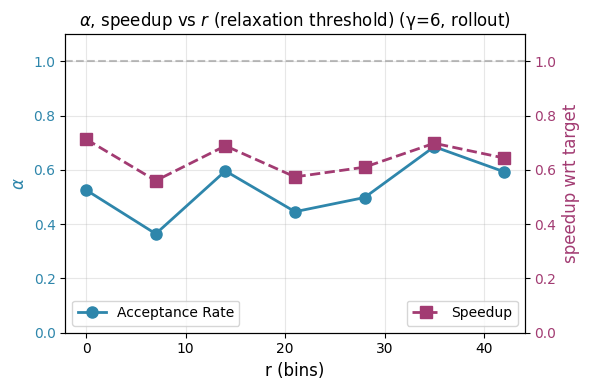


saved graph:
  acceptance_rate_vs_threshold_rollout_gamma6.png


In [13]:
# Plot acceptance rate vs relaxation threshold
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#2E86AB'
ax1.set_xlabel('r (bins)', fontsize=12)
ax1.set_ylabel(r'$\alpha$', fontsize=12, color=color1)
ax1.plot(relaxation_thresholds, acceptance_rates_r, 
         marker='o', linewidth=2, markersize=8, color=color1, label='Acceptance Rate')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='lower left')

ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.set_ylabel('speedup wrt target', fontsize=12, color=color2)
ax2.plot(relaxation_thresholds, speedups_r, marker='s', linewidth=2, markersize=8, 
         color=color2, linestyle='--', label='Speedup')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylim(0.0, 1.1)
ax2.legend(loc='lower right')

plt.title(r'$\alpha$, speedup vs $r$ (relaxation threshold)' + f' (γ={cfg.gamma}, rollout)', fontsize=12)
fig.tight_layout()
filename = f'acceptance_rate_vs_threshold_rollout_gamma{cfg.gamma}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print("\nsaved graph:")
print(f"  {filename}")



Sweeping Relaxation Thresholds

Benchmarking with relaxation threshold r=0
  Acceptance rate: 49.40%, Speedup: 0.67x

Benchmarking with relaxation threshold r=7
  Acceptance rate: 46.32%, Speedup: 0.63x

Benchmarking with relaxation threshold r=14
  Acceptance rate: 54.80%, Speedup: 0.62x

Benchmarking with relaxation threshold r=21
  Acceptance rate: 68.72%, Speedup: 0.66x

Benchmarking with relaxation threshold r=28
  Acceptance rate: 68.04%, Speedup: 0.65x

Benchmarking with relaxation threshold r=35
  Acceptance rate: 67.54%, Speedup: 0.65x

Benchmarking with relaxation threshold r=42
  Acceptance rate: 77.61%, Speedup: 0.68x


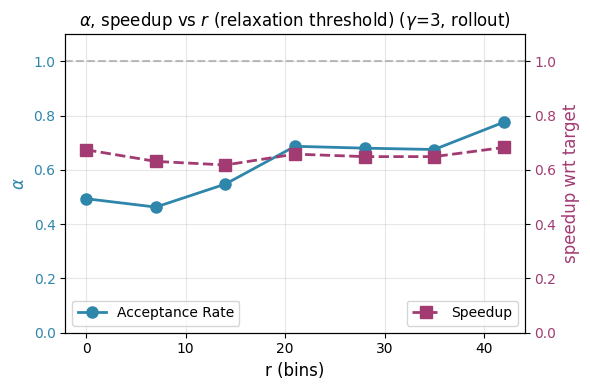


saved graph:
  acceptance_rate_vs_threshold_rollout_gamma3.png


In [14]:
# === Sweep: Acceptance Rate vs Relaxation Threshold ===
relaxation_thresholds = [0, 7, 14, 21, 28, 35, 42]
acceptance_rates_r_gamma3 = []
speedups_r_gamma3 = []

print("\n" + "=" * 80)
print("Sweeping Relaxation Thresholds")
print("=" * 80)

for r in relaxation_thresholds:
    print(f"\nBenchmarking with relaxation threshold r={r}")
    
    specdec_decoder_r = VLASpeculativeDecoderBatchedLM(
        target_model=target_model,
        draft_model=draft_model,
        target_processor=target_processor,
        gamma=3,
        temperature=cfg.temperature,
        relaxed_acceptance_r=r,
    )
    
    result_r = run_rollout_benchmark("specdec", decoder=specdec_decoder_r)
    
    acceptance_rates_r_gamma3.append(specdec_decoder_r.stats.acceptance_rate)
    mean_time_r = result_r['stats']['mean_ms'] / 1000
    speedup_r = target_mean_baseline / mean_time_r
    speedups_r_gamma3.append(speedup_r)
    print(f"  Acceptance rate: {specdec_decoder_r.stats.acceptance_rate:.2%}, Speedup: {speedup_r:.2f}x")
    
# Plot acceptance rate vs relaxation threshold
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#2E86AB'
ax1.set_xlabel('r (bins)', fontsize=12)
ax1.set_ylabel(r'$\alpha$', fontsize=12, color=color1)
ax1.plot(relaxation_thresholds, acceptance_rates_r_gamma3, 
         marker='o', linewidth=2, markersize=8, color=color1, label='Acceptance Rate')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='lower left')

ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.set_ylabel('speedup wrt target', fontsize=12, color=color2)
ax2.plot(relaxation_thresholds, speedups_r_gamma3, marker='s', linewidth=2, markersize=8, 
         color=color2, linestyle='--', label='Speedup')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylim(0.0, 1.1)
ax2.legend(loc='lower right')

plt.title(r'$\alpha$, speedup vs $r$ (relaxation threshold)' + f' ($\\gamma$=3, rollout)', fontsize=12)
fig.tight_layout()
filename = f'acceptance_rate_vs_threshold_rollout_gamma3.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print("\nsaved graph:")
print(f"  {filename}")

In [ ]:
# === Sweep: Speedup vs Gamma ===
gamma_values = list(range(2, 8))  # 1 to 7
speedups_gamma = []
acceptance_rates_gamma = []

print("\n" + "=" * 80)
print("Sweeping Gamma Values")
print("=" * 80)

for gamma in gamma_values:
    print(f"\nBenchmarking with gamma={gamma}")
    
    specdec_decoder_gamma = VLASpeculativeDecoderBatchedLM(
        target_model=target_model,
        draft_model=draft_model,
        target_processor=target_processor,
        gamma=gamma,
        temperature=cfg.temperature,
        relaxed_acceptance_r=0,
    )
    
    result_gamma = run_rollout_benchmark("specdec", decoder=specdec_decoder_gamma)
    
    mean_time = result_gamma['stats']['mean_ms'] / 1000
    speedup = target_mean_baseline / mean_time
    acceptance_rate = specdec_decoder_gamma.stats.acceptance_rate
    
    speedups_gamma.append(speedup)
    acceptance_rates_gamma.append(acceptance_rate)
    print(f"  Speedup: {speedup:.2f}x, Acceptance rate: {acceptance_rate:.2%}")




Sweeping Gamma Values

Benchmarking with gamma=2
  Speedup: 0.61x, Acceptance rate: 43.96%

Benchmarking with gamma=3
  Speedup: 0.57x, Acceptance rate: 37.41%

Benchmarking with gamma=4
  Speedup: 0.59x, Acceptance rate: 39.95%

Benchmarking with gamma=5
  Speedup: 0.60x, Acceptance rate: 40.01%

Benchmarking with gamma=6
  Speedup: 0.58x, Acceptance rate: 38.10%

Benchmarking with gamma=7
  Speedup: 0.75x, Acceptance rate: 63.90%


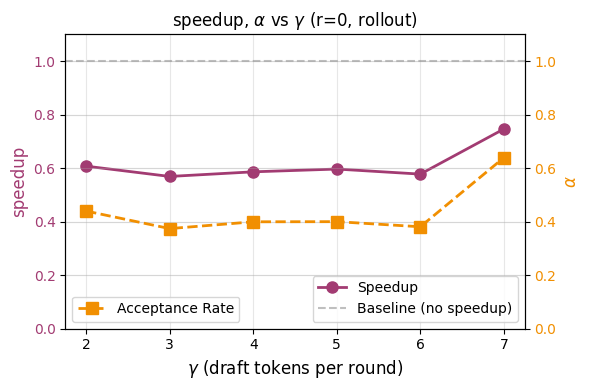


saved graph:
  speedup_vs_gamma_rollout_r0.png


In [16]:
# Plot speedup vs gamma
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#A23B72'
ax1.set_xlabel(r'$\gamma$ (draft tokens per round)', fontsize=12)
ax1.set_ylabel('speedup', fontsize=12, color=color1)
ax1.plot(gamma_values, speedups_gamma, marker='o', linewidth=2, markersize=8, 
         color=color1, label='Speedup')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (no speedup)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gamma_values)
ax1.set_ylim(0.0, 1.1)
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
color2 = '#F18F01'
ax2.set_ylabel(r'$\alpha$', fontsize=12, color=color2)
ax2.plot(gamma_values, acceptance_rates_gamma, 
         marker='s', linewidth=2, markersize=8, color=color2, 
         linestyle='--', label='Acceptance Rate')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.0, 1.1)
ax2.legend(loc='lower left')

plt.title(r'speedup, $\alpha$ vs $\gamma$' + f' (r={cfg.relaxed_acceptance_r}, rollout)', fontsize=12)
fig.tight_layout()
filename = f'speedup_vs_gamma_rollout_r{cfg.relaxed_acceptance_r}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print("\nsaved graph:")
print(f"  {filename}")

In [23]:
# === Sweep: Speedup vs Gamma ===
gamma_values = list(range(2, 8))  # 1 to 7
speedups_gamma_r7 = []
acceptance_rates_gamma_r7 = []

print("\n" + "=" * 80)
print("Sweeping Gamma Values")
print("=" * 80)

for gamma in gamma_values:
    print(f"\nBenchmarking with gamma={gamma}")
    
    specdec_decoder_gamma = VLASpeculativeDecoderBatchedLM(
        target_model=target_model,
        draft_model=draft_model,
        target_processor=target_processor,
        gamma=gamma,
        temperature=cfg.temperature,
        relaxed_acceptance_r=7,
    )
    
    result_gamma = run_rollout_benchmark("specdec", decoder=specdec_decoder_gamma)
    
    mean_time = result_gamma['stats']['mean_ms'] / 1000
    speedup = target_mean_baseline / mean_time
    acceptance_rate = specdec_decoder_gamma.stats.acceptance_rate
    
    speedups_gamma_r7.append(speedup)
    acceptance_rates_gamma_r7.append(acceptance_rate)
    print(f"  Speedup: {speedup:.2f}x, Acceptance rate: {acceptance_rate:.2%}")


Sweeping Gamma Values

Benchmarking with gamma=2
  Speedup: 0.60x, Acceptance rate: 44.13%

Benchmarking with gamma=3
  Speedup: 0.59x, Acceptance rate: 41.98%

Benchmarking with gamma=4
  Speedup: 0.49x, Acceptance rate: 36.89%

Benchmarking with gamma=5
  Speedup: 0.66x, Acceptance rate: 48.72%

Benchmarking with gamma=6
  Speedup: 0.57x, Acceptance rate: 38.20%

Benchmarking with gamma=7
  Speedup: 0.56x, Acceptance rate: 38.41%


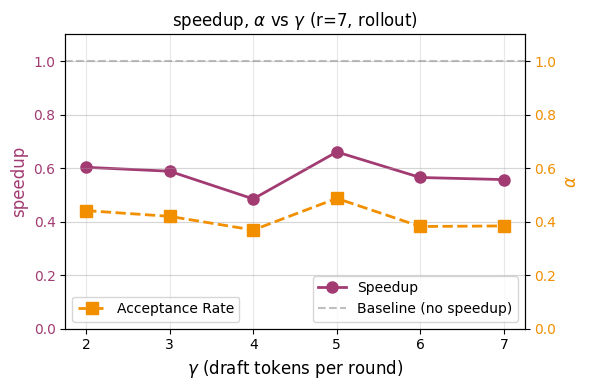


saved graph:
  speedup_vs_gamma_rollout_r7.png


In [24]:
# Plot speedup vs gamma
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#A23B72'
ax1.set_xlabel(r'$\gamma$ (draft tokens per round)', fontsize=12)
ax1.set_ylabel('speedup', fontsize=12, color=color1)
ax1.plot(gamma_values, speedups_gamma_r7, marker='o', linewidth=2, markersize=8, 
         color=color1, label='Speedup')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (no speedup)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gamma_values)
ax1.set_ylim(0.0, 1.1)
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
color2 = '#F18F01'
ax2.set_ylabel(r'$\alpha$', fontsize=12, color=color2)
ax2.plot(gamma_values, acceptance_rates_gamma_r7, 
         marker='s', linewidth=2, markersize=8, color=color2, 
         linestyle='--', label='Acceptance Rate')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.0, 1.1)
ax2.legend(loc='lower left')

plt.title(r'speedup, $\alpha$ vs $\gamma$' + f' (r=7, rollout)', fontsize=12)
fig.tight_layout()
filename = f'speedup_vs_gamma_rollout_r7.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print("\nsaved graph:")
print(f"  {filename}")

In [25]:
# === Sweep: Speedup vs Gamma ===
gamma_values = list(range(2, 8))  # 1 to 7
speedups_gamma_r255 = []
acceptance_rates_gamma_r255 = []

print("\n" + "=" * 80)
print("Sweeping Gamma Values")
print("=" * 80)

for gamma in gamma_values:
    print(f"\nBenchmarking with gamma={gamma}")
    
    specdec_decoder_gamma = VLASpeculativeDecoderBatchedLM(
        target_model=target_model,
        draft_model=draft_model,
        target_processor=target_processor,
        gamma=gamma,
        temperature=cfg.temperature,
        relaxed_acceptance_r=255,
    )
    
    result_gamma = run_rollout_benchmark("specdec", decoder=specdec_decoder_gamma)
    
    mean_time = result_gamma['stats']['mean_ms'] / 1000
    speedup = target_mean_baseline / mean_time
    acceptance_rate = specdec_decoder_gamma.stats.acceptance_rate
    
    speedups_gamma_r255.append(speedup)
    acceptance_rates_gamma_r255.append(acceptance_rate)
    print(f"  Speedup: {speedup:.2f}x, Acceptance rate: {acceptance_rate:.2%}")


Sweeping Gamma Values

Benchmarking with gamma=2
  Speedup: 0.69x, Acceptance rate: 100.00%

Benchmarking with gamma=3
  Speedup: 0.79x, Acceptance rate: 100.00%

Benchmarking with gamma=4
  Speedup: 0.79x, Acceptance rate: 100.00%

Benchmarking with gamma=5
  Speedup: 0.80x, Acceptance rate: 100.00%

Benchmarking with gamma=6
  Speedup: 0.87x, Acceptance rate: 100.00%

Benchmarking with gamma=7
  Speedup: 0.94x, Acceptance rate: 100.00%


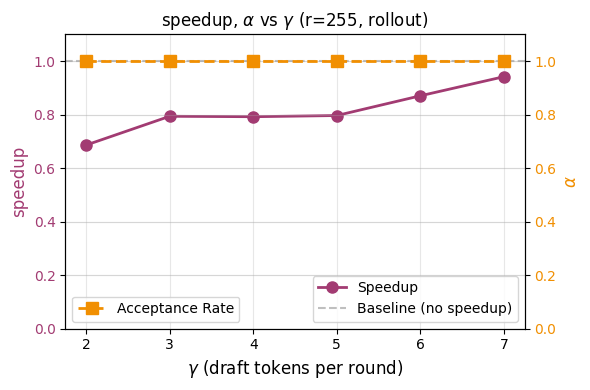


saved graph:
  speedup_vs_gamma_rollout_r255.png


In [26]:
# Plot speedup vs gamma
fig, ax1 = plt.subplots(figsize=(6, 4))

color1 = '#A23B72'
ax1.set_xlabel(r'$\gamma$ (draft tokens per round)', fontsize=12)
ax1.set_ylabel('speedup', fontsize=12, color=color1)
ax1.plot(gamma_values, speedups_gamma_r255, marker='o', linewidth=2, markersize=8, 
         color=color1, label='Speedup')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (no speedup)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gamma_values)
ax1.set_ylim(0.0, 1.1)
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
color2 = '#F18F01'
ax2.set_ylabel(r'$\alpha$', fontsize=12, color=color2)
ax2.plot(gamma_values, acceptance_rates_gamma_r255, 
         marker='s', linewidth=2, markersize=8, color=color2, 
         linestyle='--', label='Acceptance Rate')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.0, 1.1)
ax2.legend(loc='lower left')

plt.title(r'speedup, $\alpha$ vs $\gamma$' + f' (r=255, rollout)', fontsize=12)
fig.tight_layout()
filename = f'speedup_vs_gamma_rollout_r255.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print("\nsaved graph:")
print(f"  {filename}")